## Additional figures created in the MSc report

#### Sonia Laguna - ETH Zurich, September 2022

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import os
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import correlate2d
import skimage
import hdf5storage
import statistics
import matplotlib.colors as colors
from sklearn.metrics import normalized_mutual_info_score, adjusted_mutual_info_score
import matplotlib.transforms as mtrans
from scipy.signal import hilbert
from scipy.stats import pearsonr
from sklearn.metrics import r2_score
import scipy
from scipy.stats import spearmanr
from scipy.stats import kendalltau
import matplotlib.patches as mpatches
from scipy.stats import entropy

### Violin plots: ∆SoS of the sampled reconstructions from each uncertainty estimation method

In [2]:
def add_label(violin, label, labels_l):
    color = violin["bodies"][0].get_facecolor().flatten()
    labels_l.append((mpatches.Patch(color=color), label))
def set_axis_style(ax, labels):
    ax.xaxis.set_tick_params(direction='out')
    ax.xaxis.set_ticks_position('bottom')
    ax.set_xticks(np.arange(1, len(labels) + 1), labels=labels, fontsize=7)
    ax.set_xlim(0.25, len(labels) + 0.75)

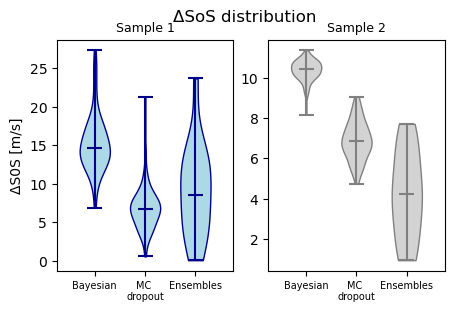

In [3]:
#Loading dSoS distributions
b = np.load('/scratch_net/biwidl307/sonia/USImageReconstruction-Sonia/results/new_dSoS_bay_CA.npy')
d = np.load('/scratch_net/biwidl307/sonia/USImageReconstruction-Sonia/results/new_dSoS_drop_CA.npy')
e = np.load('/scratch_net/biwidl307/sonia/USImageReconstruction-Sonia/results/new_dSoS_ensembles_CA.npy')
type = ['Bayesian','MC \ndropout','Ensembles']
fig2, (ax1, ax2) = plt.subplots(1,2,figsize = (5,3))
ax1.set_title('Sample 1',fontsize=9)
ax1.set_ylabel('ΔS0S [m/s]')
part1 = ax1.violinplot([b[5][2],d[5][2],e[4][2]], showmedians = True, widths = 0.6)

for body in part1['bodies']:
    body.set_facecolor('lightblue')
    body.set_edgecolor('darkblue')
    body.set_alpha(1)
part1['cmaxes'].set_color('darkblue')
part1['cmins'].set_color('darkblue')
part1['cbars'].set_color('darkblue')
part1['cmedians'].set_color('darkblue')
set_axis_style(ax1, type)

ax2.set_title('Sample 2',fontsize=9)
parts = ax2.violinplot([b[3][2],d[3][2],e[3][1]], showmedians = True, widths = 0.6)
set_axis_style(ax2, type)

for body in parts['bodies']:
    body.set_facecolor('lightgray')
    body.set_edgecolor('gray')
    body.set_alpha(1)
parts['cmaxes'].set_color('gray')
parts['cmins'].set_color('gray')
parts['cbars'].set_color('gray')
parts['cmedians'].set_color('gray')
plt.suptitle('ΔSoS distribution')
# pk = 0
# while os.path.isfile('/scratch_net/biwidl307/sonia/kk/violin_mean' + str(pk) + '.pdf'):
#     pk += 1
# plt.savefig('/scratch_net/biwidl307/sonia/kk/violin_mean' + str(pk) + '.pdf')
plt.show()

### RMSE plots

In [4]:
"""
Functions
"""
def RMSE_duo(img, recon, lbfgs):
    """
    Args:
        img: Ground truth img
        recon: Reconstructed VN
        lbfgs: Reconstructed LBFGS

    Returns: RMSE

    """
    RMSEvn = []
    RMSElbfgs = []
    for p in range(img.shape[0]):
        xtrue = 1 / img[p, ...]
        recon_vn = recon[p, ...]
        recon_l = lbfgs[p, ...]
        RMSEvn.append(np.sqrt(np.mean(np.power(recon_vn - xtrue, 2))))
        RMSElbfgs.append(np.sqrt(np.mean(np.power(np.transpose(recon_l) - xtrue, 2))))
    return RMSEvn, RMSElbfgs

def RMSE_single(img, recon):
    """
    Args:
        img: Ground truth img
        recon: Reconstructed

    Returns: RMSE
    """
    RMSErecon = []
    for p in range(img.shape[0]):
        xtrue = 1 / img[p, ...]
        recon_s = recon[p, ...]
        RMSErecon.append(np.sqrt(np.mean(np.power(recon_s - xtrue, 2))))
    return RMSErecon

#### Initial configuration

In [5]:
# filename = ['test-syn-0.0-0.0-test-train_VS_15comb_fullpipeline_30.mat']
# filename = ['test-syn-0.0-0.0-patchy-train_VS_15comb_IC_30.mat']
filename = ['test-syn-0.0-0.0-test-fullpipeline_testset_6comb_32_imgs.mat']
# filename = ['test-syn-0.0-0.1-patchy-testset_ideal_MS_32_imgs.mat']
# filename = ['test-syn-0.0-0.5-patchy-testset_ideal_MS_32_imgs.mat']
# filename = ['test-syn-0.0-0.9-patchy-testset_ideal_MS_32_imgs.mat']

#Original file of the corresponding filename
orig_data = hdf5storage.loadmat('/scratch_net/biwidl307/sonia/data_original/test/fullpipeline_testset_6comb_32_imgs.mat') 
# orig_data = hdf5storage.loadmat('/scratch_net/biwidl307/sonia/data_original/VS/train_VS_15comb_fullpipeline_30.mat')

#### Comparing RMSE of different VN configurations

In [6]:
#Regular VN
RMSEdrop = []
titles = []
exps_VN = ['4_ICFP_reg1e5_tau5', '4_ICFP_reg1e5_tau5_L2','4_ICFP_reg1e6_tau5',
           '4_ICFP_reg1e5_tau.25', '4_ICFP_reg1e5_tau2.5_L2','32_mix_ideal_20l_reg_mix', '10_ICFP_reg1e5_tau5']
titles = ['Act: 1e5, \n tau 5, \n loss L1, \n Data: \n 12-4', 
          'Act: 1e5, \n tau 5, \n loss L2, \n Data: \n 12-4','Act: 1e6, \n tau 5, \n loss L1 , \n Data: \n 12-4',
          'Act: 1e5,\n Tau: 0.25,\n loss L1, \n Data: \n 12-4', 'Act: 1e5, \n Tau: 0.25, \n loss L1, \n Data: \n 12-4',
          'Act: 1e5, \n tau 5, \n loss L1 \n Data: \n 11-4-1','Act: 1e5, \n tau 5, \n loss L1 \n Data: \n 6-10']
for i in range(len(exps_VN)):
    try: 
        vn_path = os.path.join(
            '/scratch_net/biwidl307/sonia/USImageReconstruction-Sonia/runs/',exps_VN[i],'eval-vn-120000',
            filename[0])
        vn = hdf5storage.loadmat(vn_path)
    except:
        print('Loading from scratch second', exps_VN[i])
        vn_path = os.path.join(
            '/scratch-second/sonia_second/USImageReconstruction-Sonia/runs/',exps_VN[i],'eval-vn-120000',
            filename[0])
        vn = hdf5storage.loadmat(vn_path)
    RMSEdrop.append(RMSE_single(vn['gt_slowness'][...], vn['recon']))

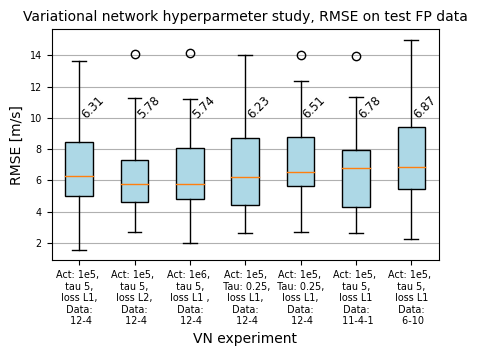

In [7]:
fig1, ax1 = plt.subplots(figsize = (5,3))
ax1.set_title('Variational network hyperparmeter study, RMSE on test FP data', size = 'medium')
bplot1 =ax1.boxplot(RMSEdrop, vert=True, patch_artist=True)
ax1.set_xticklabels(titles)
ax1.set_ylabel('RMSE [m/s]')
ax1.set_xlabel('VN experiment')
for i in range(len(RMSEdrop)):
    ax1.text(i+1, 10, np.around(statistics.median(RMSEdrop[i]), decimals =2), rotation = 45,  ha='left', size = 'small' )
ax1.tick_params(labelsize = 'x-small')
ax1.yaxis.grid(True)
# ax1.set_aspect(0.5)
# ax1.tick_params(labelrotation=20)

# fill with colors
colors = ['pink', 'lightblue', 'lightgreen']
colors = ['lightblue']*7
for bplot in [bplot1]:
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)
# pk = 0
# while os.path.isfile('/scratch_net/biwidl307/sonia/kk/figures/RMSE_VN' + str(pk) + '.pdf'):
#     pk += 1
# plt.savefig('/scratch_net/biwidl307/sonia/kk/figures/RMSE_VN' + str(pk) + '.pdf')
plt.show()
plt.show()

### Comparing RMSE of all uncertainty estimation methods, VN and LBFGS and mean, mode, median

In [8]:
"""
Ensembles approach
"""
gt = '4_ICFP_reg1e5_tau5' # Name of the plain VN model

exps = [ #Ensembles experiments
    '4_ICFP_reg1e5_tau5_5filt_20lay',
#     '4_ICFP_reg1e5_tau5_8filt_25lay',  
    '4_ICFP_reg1e5_tau5_8filt_15lay',
    '4_ICFP_reg1e5_tau5_8filt_20lay',
    '4_ICFP_reg1e5_tau5_16filt_25lay',
    '4_ICFP_reg1e5_tau5_16filt_15lay',
    '4_ICFP_reg1e5_tau5_16filt_20lay', '4_ICFP_reg1e5_tau5_32filt_25lay', '4_ICFP_reg1e5_tau5_32filt_15lay',
    '4_ICFP_reg1e6_tau5', '4_ICFP_reg1e5_tau.25', '4_ICFP_reg1e5_tau5', '4_ICFP_reg1e5_tau5_L2',
    '4_ICFP_reg1e5_tau2.5_L2'
]

titles_drop = ['ensembles']
docs = ['eval-vn-120000']
experiment = [' Train ICFP - Test FP']

In [9]:
for type in range(len(docs)):
    titles = []
    titles_m = []
    RMSEdrop = []
    RMSEdrop_m = []
    uncert = {'mean': [], 'stdev': [], 'samples': []}
    # Loading combinations of ensembles
    for exp in range(len(exps)):
        dir = os.path.join('/scratch_net/biwidl307/sonia/USImageReconstruction-Sonia/runs/', exps[exp], docs[type])
        mat = hdf5storage.loadmat(os.path.join(dir, filename[0]))
        vn_path = os.path.join('/scratch_net/biwidl307/sonia/USImageReconstruction-Sonia/runs/',gt,'eval-vn-120000',
            filename[0])
        vn = hdf5storage.loadmat(vn_path)
        lbfgs_path = '/scratch_net/biwidl307/sonia/USImageReconstruction-Sonia/runs/lbfgs/lbfgs-' + filename[0]
        lbfgs_recon = hdf5storage.loadmat(lbfgs_path)
        if np.size(uncert['samples']) == 0:
            uncert['samples'] = mat['recon'][None,...]
        else:
            uncert['samples'] = np.concatenate((uncert['samples'], mat['recon'][None,...]))
    uncert['samples'] = np.concatenate((uncert['samples'],np.reshape(lbfgs_recon['recon_lbfgs'], [lbfgs_recon['recon_lbfgs'].shape[0],64,84])[None,...]))
    
    uncert['mean'] = np.mean(uncert['samples'], axis=0)
    uncert['stdev'] = np.std(uncert['samples'], axis=0)
    #Logging the RMSE
    RMSEdrop.append(RMSE_single(mat['gt_slowness'][...], uncert['mean']))
    RMSEdrop_m.append(RMSE_single(mat['gt_slowness'][...], uncert['mean'])) #Saving it twice, for analysis of mean, mode, median
    titles.append(titles_drop[0])
    titles_m.append(titles_drop[0]) #Saving it twice, for analysis of mean, mode, median

In [10]:
"""
Logging RMSE resulting from using the median and mode as final SoS reconstruction
"""
uncert['mean'] = np.median(uncert['samples'], axis=0)
RMSEdrop_m.append(RMSE_single(mat['gt_slowness'][...], uncert['mean']))
titles_m.append(titles_drop[0] + '\n median')

mode= scipy.stats.mode(uncert['samples'], axis=0)
uncert['mean'] = mode.mode[0]
RMSEdrop_m.append(RMSE_single(mat['gt_slowness'][...], uncert['mean']))
titles_m.append(titles_drop[0]+ '\n mode')

/tmp/ipykernel_28576/2319917988.py:8: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode= scipy.stats.mode(uncert['samples'], axis=0)


In [11]:
"""
MC dropout approach
"""
exps = ['4_ICFP_reg1e5_tau5_dropK0.5']
titles_drop = [ 'K0.5']
# docs = ['100_eval-vn-120000']
docs = ['eval-vn-120000']

In [12]:
for type in range(len(docs)):
    for exp in range(len(exps)):
        dir = os.path.join('/scratch_net/biwidl307/sonia/USImageReconstruction-Sonia/runs/', exps[exp], docs[type])
        uncert = {'mean': [], 'stdev': []}
        mat = hdf5storage.loadmat(os.path.join(dir, filename[0]))

        uncert['mean'] = np.mean(mat['recon'], axis=0)
        uncert['stdev'] = np.std(mat['recon'], axis=0)

        #Logging the RMSE
        RMSEdrop.append(RMSE_single(mat['gt_slowness'][1,...], uncert['mean']))
        titles.append(titles_drop[exp])
        RMSEdrop_m.append(RMSE_single(mat['gt_slowness'][1,...], uncert['mean'])) #Saving it twice, for analysis of mean, mode, median
        titles_m.append(titles_drop[exp]) #Saving it twice, for analysis of mean, mode, median

In [13]:
for type in range(len(docs)):
    for exp in range(len(exps)):
        dir = os.path.join('/scratch_net/biwidl307/sonia/USImageReconstruction-Sonia/runs/', exps[exp], docs[type])
        uncert = {'mean': [], 'stdev': []}
        #Logging the median to the RMSE
        mat = hdf5storage.loadmat(os.path.join(dir, filename[0]))
        uncert['mean'] = np.median(mat['recon'], axis=0)
        RMSEdrop_m.append(RMSE_single(mat['gt_slowness'][1,...], uncert['mean'])) 
        titles_m.append(titles_drop[exp] +'\n median')
        #Logging the mode to the RMSE
        mode = scipy.stats.mode(mat['recon'], axis=0)
        uncert['mean'] = mode.mode[0]
        RMSEdrop_m.append(RMSE_single(mat['gt_slowness'][1,...], uncert['mean']))
        titles_m.append(titles_drop[exp] +'\n mode')

/tmp/ipykernel_28576/2863173825.py:11: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = scipy.stats.mode(mat['recon'], axis=0)


In [14]:
"""
Bayesian Variational Inference approach
"""
exps = ['4_ICFP_reg1e5_tau5_KLa-1b-1']
titles_drop = ['a-1b-1']
# docs = ['100_eval-vn-120000']
docs = ['eval-vn-120000']

In [15]:
for type in range(len(docs)):
        for exp in range(len(exps)):
            dir = os.path.join('/scratch_net/biwidl307/sonia/USImageReconstruction-Sonia/runs/', exps[exp], docs[type])
            uncert = {'mean': [], 'stdev': []}
            mat = hdf5storage.loadmat(os.path.join(dir, filename[0]))

            uncert['mean'] = np.mean(mat['recon'], axis=0)
            uncert['stdev'] = np.std(mat['recon'], axis=0)

            #Logging the RMSE
            RMSEdrop.append(RMSE_single(mat['gt_slowness'][1, ...], uncert['mean']))
            titles.append(titles_drop[exp])
            RMSEdrop_m.append(RMSE_single(mat['gt_slowness'][1, ...], uncert['mean'])) #Saving it twice, for analysis of mean, mode, median
            titles_m.append(titles_drop[exp]) #Saving it twice, for analysis of mean, mode, median

In [16]:
for type in range(len(docs)):
    for exp in range(len(exps)):
        dir = os.path.join('/scratch_net/biwidl307/sonia/USImageReconstruction-Sonia/runs/', exps[exp], docs[type])
        uncert = {'mean': [], 'stdev': []}
        mat = hdf5storage.loadmat(os.path.join(dir, filename[0]))
        #Logging median
        uncert['mean'] = np.median(mat['recon'], axis=0)
        RMSEdrop_m.append(RMSE_single(mat['gt_slowness'][1, ...], uncert['mean']))
        titles_m.append(titles_drop[exp] + '\n median')
        #Logging mode
        mode= scipy.stats.mode(mat['recon'], axis=0)
        uncert['mean'] = mode.mode[0]
        RMSEdrop_m.append(RMSE_single(mat['gt_slowness'][1, ...], uncert['mean']))
        titles_m.append(titles_drop[exp] + '\n mode')

/tmp/ipykernel_28576/2585093010.py:11: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode= scipy.stats.mode(mat['recon'], axis=0)


In [17]:
"""
Logging plain VN and LBFGS RMSE
"""
RMSEvn, RMSElbfgs = RMSE_duo(mat['gt_slowness'][1,...], vn['recon'], lbfgs_recon['recon_lbfgs'])

#Paired data
rest_VN = []
rest_LBFGS = []
titles_vn = titles.copy()
titles_lbfgs = titles.copy()
for k in range(len(RMSEdrop)):
    rest_VN.append(np.asarray(RMSEdrop[k]) - np.asarray(RMSEvn))
    rest_LBFGS.append(np.asarray(RMSEdrop[k]) - np.asarray(RMSElbfgs))
rest_VN.append(np.asarray(RMSElbfgs) - np.asarray(RMSEvn))
rest_LBFGS.append(np.asarray(RMSEvn) - np.asarray(RMSElbfgs))
titles_vn.append('LBFGS')
titles_lbfgs.append('VN')

RMSEdrop.append(RMSEvn)
RMSEdrop.append(RMSElbfgs)
titles.append('VN')
titles.append('LBFGS')
RMSEdrop_m.append(RMSEvn) #Saving it twice, for analysis of mean, mode, median
RMSEdrop_m.append(RMSElbfgs)
titles_m.append('VN') #Saving it twice, for analysis of mean, mode, median
titles_m.append('LBFGS')

#### Plotting the RMSE of reconstructing SoS using the mean, median and mode of the sampled data

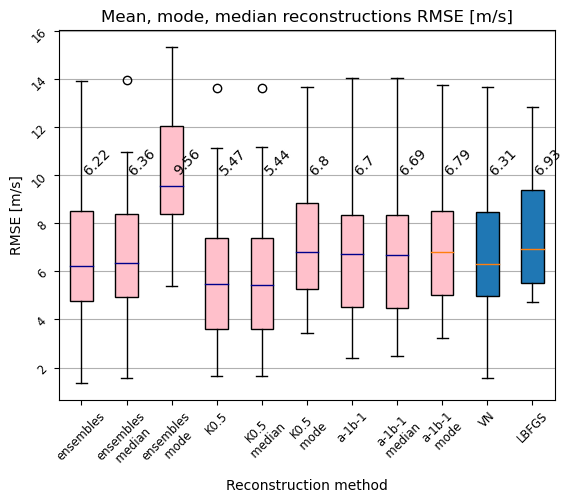

In [18]:
"""
Mean, mode, median
"""
titles = ['Ensembles \n mean', 'Ensembles \n median','Ensembles \n mode','MC dropout \n mean','MC dropout \n median','MC dropout \n mode','Bayesian \n mean','Bayesian \n median','Bayesian \n mode' ]
fig1, ax1 = plt.subplots()
ax1.set_title('Mean, mode, median reconstructions RMSE [m/s]' )
bplot1 =ax1.boxplot(RMSEdrop_m, vert=True, patch_artist=True)
ax1.set_xticklabels(titles_m)
ax1.set_xlabel('Reconstruction method')
ax1.set_ylabel('RMSE [m/s]')
ax1.yaxis.grid(True)
ax1.tick_params(labelsize = 'small')
for i in range(len(RMSEdrop_m)):
    ax1.text(i+1, 10, np.around(statistics.median(RMSEdrop_m[i]), decimals =2), rotation = 45,  ha='left', size = 'medium' )
ax1.tick_params(labelrotation=45)
colors = ['pink']*9
for bplot in [bplot1]:
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)
    for patch, color in zip(bplot['medians'], 'darkblue'):
        patch.set_color('darkblue')
# pk = 0
# while os.path.isfile('/scratch_net/biwidl307/sonia/kk/figures/RMSE_mode' + str(pk) + '.pdf'):
#     pk += 1
# plt.savefig('/scratch_net/biwidl307/sonia/kk/figures/RMSE_mode' + str(pk) + '.pdf')
plt.show()

#### Plotting the RMSE of reconstructing SoS using the final three uncertainty estimation methods

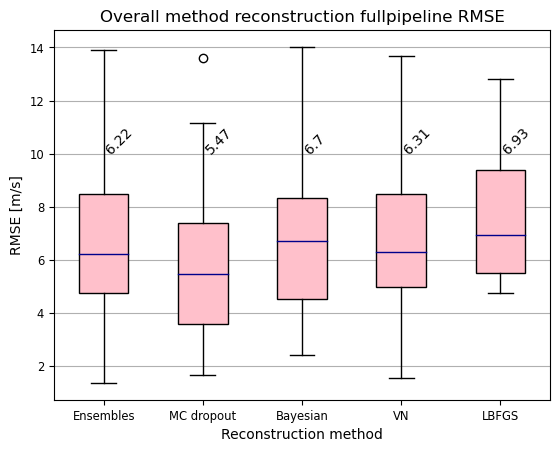

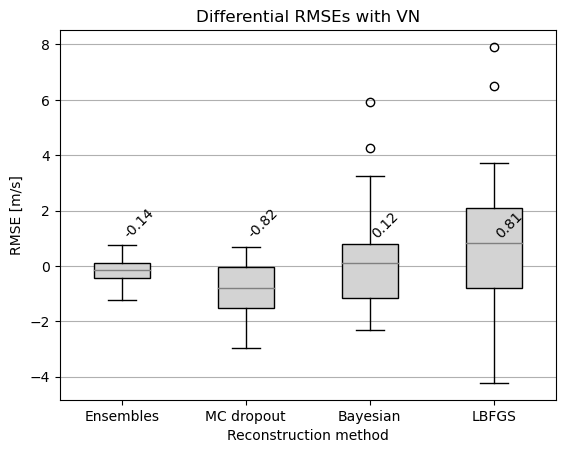

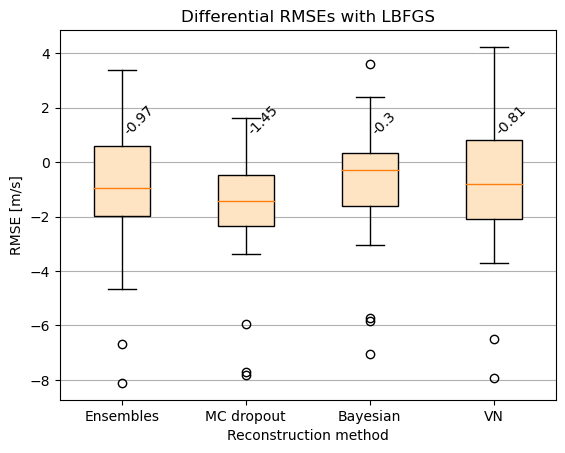

In [19]:
"""
Overall RMSE of all models
"""
fig1, ax1 = plt.subplots()
ax1.set_title('Overall method reconstruction fullpipeline RMSE' )
bplot1 =ax1.boxplot(RMSEdrop, vert=True, patch_artist=True)
titles = ['Ensembles', 'MC dropout', 'Bayesian', 'VN', 'LBFGS']
ax1.set_xticklabels(titles)
ax1.tick_params(labelsize = 'small')
ax1.yaxis.grid(True)
for i in range(len(RMSEdrop)):
    ax1.text(i+1, 10, np.around(statistics.median(RMSEdrop[i]), decimals =2), rotation = 45,  ha='left', size = 'medium' )
ax1.set_xlabel('Reconstruction method')
ax1.set_ylabel('RMSE [m/s]')
colors = ['pink']*9
for bplot in [bplot1]:
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)
    for patch, color in zip(bplot['medians'], 'darkblue'):
        patch.set_color('darkblue')
# pk = 0
# while os.path.isfile('/scratch_net/biwidl307/sonia/kk/figures/RMSE_tot' + str(pk) + '.pdf'):
#     pk += 1
# plt.savefig('/scratch_net/biwidl307/sonia/kk/figures/RMSE_tot' + str(pk) + '.pdf')
plt.show()

"""
Differential RMSE of all models
"""
fig1, ax1 = plt.subplots()
ax1.set_title('Differential RMSEs with VN' )
bplot2 = ax1.boxplot(rest_VN, vert=True, patch_artist=True)
ax1.yaxis.grid(True)
titles_vn = ['Ensembles', 'MC dropout', 'Bayesian', 'LBFGS']
ax1.set_xticklabels(titles_vn)
ax1.set_xlabel('Reconstruction method')
ax1.set_ylabel('RMSE [m/s]')
for i in range(len(rest_VN)):
    ax1.text(i+1, 1, np.around(statistics.median(rest_VN[i]), decimals =2), rotation = 45,  ha='left', size = 'medium' )
colors = ['lightgray']*4
for bplot in [bplot2]:
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)
    for patch, color in zip(bplot['medians'], 'darkgray'):
        patch.set_color('gray')
# pk = 0
# while os.path.isfile('/scratch_net/biwidl307/sonia/kk/figures/RMSE_dif_1' + str(pk) + '.pdf'):
#     pk += 1
# plt.savefig('/scratch_net/biwidl307/sonia/kk/figures/RMSE_dif_1' + str(pk) + '.pdf')
plt.show()

fig1, ax1 = plt.subplots()
ax1.set_title('Differential RMSEs with LBFGS')
ax1.yaxis.grid(True)
bplot3 = ax1.boxplot(rest_LBFGS,
#             widths = 0.3,
            vert=True, patch_artist=True)
titles_lbfgs = ['Ensembles', 'MC dropout', 'Bayesian', 'VN']
ax1.set_xticklabels(titles_lbfgs)
ax1.set_xlabel('Reconstruction method')
ax1.set_ylabel('RMSE [m/s]')
for i in range(len(rest_LBFGS)):
    ax1.text(i + 1, 1, np.around(statistics.median(rest_LBFGS[i]), decimals=2), rotation=45, ha='left', size='medium')
    colors = ['bisque']*4
    
for bplot in [bplot3]:
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)
# pk = 0
# while os.path.isfile('/scratch_net/biwidl307/sonia/kk/figures/RMSE_dif_2' + str(pk) + '.pdf'):
#     pk += 1
# plt.savefig('/scratch_net/biwidl307/sonia/kk/figures/RMSE_dif_2' + str(pk) + '.pdf')
plt.show()

### Studying MC dropout parameters: dropout rates and sampling in terms of RMSE

In [20]:
"""
MC dropout configuration
"""
exps = ['32_mix_ideal_20l_reg_mix_drop0.1', '32_mix_ideal_20l_reg_mix_drop0.25','32_mix_ideal_20l_reg_mix_drop0.25P0.1','32_mix_ideal_20l_reg_mix_drop0.25P0.25','32_mix_ideal_20l_reg_mix_drop0.25P0.5','32_mix_ideal_20l_reg_mix_drop0.25P0.75','32_mix_ideal_20l_reg_mix_drop0.35','32_mix_ideal_20l_reg_mix_drop0.5','32_mix_ideal_20l_reg_mix_drop0.5P0.1','32_mix_ideal_20l_reg_mix_drop0.5P0.25','32_mix_ideal_20l_reg_mix_drop0.5P0.5','32_mix_ideal_20l_reg_mix_drop0.5P0.75','32_mix_ideal_20l_reg_mix_drop0.75',]
titles_drop =exps
docs = ['eval-200-vn-120000']

In [21]:
# Loading data
titles = []
RMSEdrop=[]
for type in range(len(docs)):
    for exp in range(len(exps)):
        dir = os.path.join('/scratch-second/sonia_second/USImageReconstruction-Melanie/runs/', exps[exp], docs[type])
        uncert = {'mean': [], 'stdev': []}
        mat = hdf5storage.loadmat(os.path.join(dir, filename[0]))

        uncert['mean'] = np.mean(mat['recon'], axis=0)

        RMSEdrop.append(RMSE_single(mat['gt_slowness'][1,...], uncert['mean']))
        titles.append(titles_drop[exp])

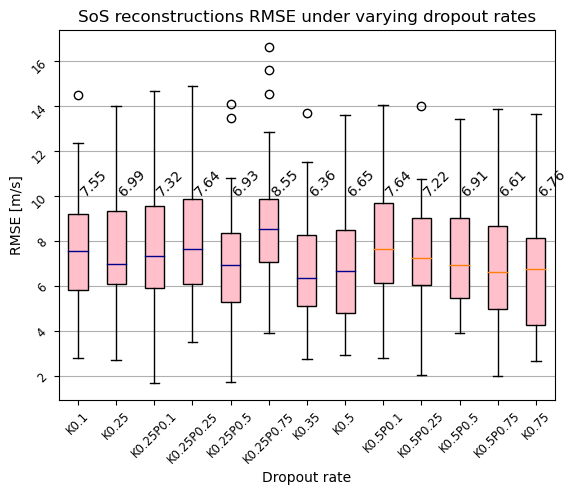

In [22]:
# Plotting RMSEs of different dropout rates
titles = ['K0.1','K0.25','K0.25P0.1','K0.25P0.25','K0.25P0.5','K0.25P0.75','K0.35','K0.5','K0.5P0.1','K0.5P0.25','K0.5P0.5','K0.5P0.75','K0.75']
fig1, ax1 = plt.subplots()
ax1.set_title('SoS reconstructions RMSE under varying dropout rates' )
bplot1 =ax1.boxplot(RMSEdrop, vert=True, patch_artist=True)
ax1.set_xticklabels(titles)
ax1.set_xlabel('Dropout rate')
ax1.yaxis.grid(True)
ax1.set_ylabel('RMSE [m/s]')
ax1.tick_params(labelsize = 'small')
for i in range(len(RMSEdrop)):
    ax1.text(i+1, 10, np.around(statistics.median(RMSEdrop[i]), decimals =2), rotation = 45,  ha='left', size = 'medium' )
ax1.tick_params(labelrotation=45)
colors = ['pink']*13
for bplot in [bplot1]:
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)
    for patch, color in zip(bplot['medians'], 'darkblue'):
        patch.set_color('darkblue')
# pk = 0
# while os.path.isfile('/scratch_net/biwidl307/sonia/kk/figures/RMSE_dropout' + str(pk) + '.pdf'):
#     pk += 1
# plt.savefig('/scratch_net/biwidl307/sonia/kk/figures/RMSE_dropout' + str(pk) + '.pdf')
plt.show()

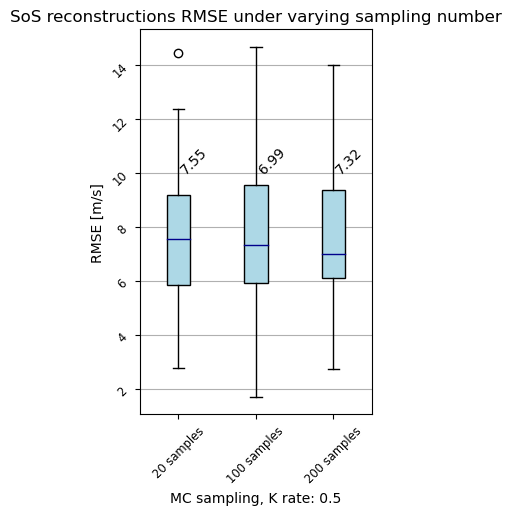

In [23]:
# Plotting RMSEs of different samples of one dropout rate
titles = ['20 samples', '100 samples', '200 samples']
fig1, ax1 = plt.subplots(figsize = (3,5))
ax1.set_title('SoS reconstructions RMSE under varying sampling number' )
bplot1 =ax1.boxplot([RMSEdrop[0],RMSEdrop[2],RMSEdrop[1]], vert=True, patch_artist=True)
ax1.set_xticklabels(titles)
ax1.set_xlabel('MC sampling, K rate: 0.5')
ax1.set_ylabel('RMSE [m/s]')
ax1.tick_params(labelsize = 'small')
ax1.yaxis.grid(True)
for i in range(len(titles)):
    ax1.text(i+1, 10, np.around(statistics.median(RMSEdrop[i]), decimals =2), rotation = 45,  ha='left', size = 'medium' )
ax1.tick_params(labelrotation=45)
colors = ['lightblue']*3
for bplot in [bplot1]:
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)
    for patch, color in zip(bplot['medians'], 'darkblue'):
        patch.set_color('darkblue')
# pk = 0
# while os.path.isfile('/scratch_net/biwidl307/sonia/kk/figures/RMSE_dropout_sam' + str(pk) + '.pdf'):
#     pk += 1
# plt.savefig('/scratch_net/biwidl307/sonia/kk/figures/RMSE_dropout_samp' + str(pk) + '.pdf')
plt.show()

### Studying Bayesian Variational Inference parameters

In [24]:
"""
Bayesian Variational Inference configuration
"""
exps= ['32_mix_ideal_20l_reg_mix_KL_a0b-1_un','32_mix_ideal_20l_reg_mix_KL_a-1b-1_un','32_mix_ideal_20l_reg_mix_KL_a1b1e3','32_mix_ideal_20l_reg_mix_KL_a1b1' ]
titles_drop = exps
# docs = ['100_eval-vn-120000']
docs = ['new_fullpipeline_eval-50-vn-120000']
samp = ['50']

In [25]:
# Loading data
titles = []
RMSEdrop = []
for type in range(len(docs)):
        for exp in range(len(exps)):
            dir = os.path.join('/scratch-second/sonia_second/USImageReconstruction-Melanie/runs/', exps[exp], docs[type])
            uncert = {'mean': [], 'stdev': []}
            mat = hdf5storage.loadmat(os.path.join(dir, filename[0]))
            uncert['mean'] = np.mean(mat['recon'], axis=0)
            uncert['stdev'] = np.std(mat['recon'], axis=0)
            #Logging the RMSE
            RMSEdrop.append(RMSE_single(mat['gt_slowness'][1, ...], uncert['mean']))
            titles.append(titles_drop[type])

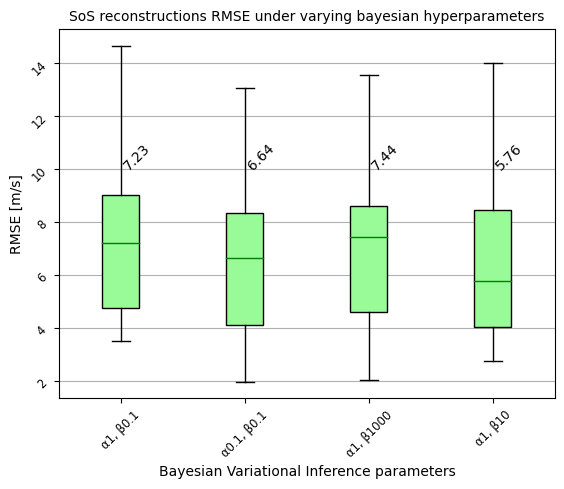

In [26]:
# Plotting results
titles = ['α1, β0.1','α0.1, β0.1','α1, β1000','α1, β10']
fig1, ax1 = plt.subplots()
ax1.set_title('SoS reconstructions RMSE under varying bayesian hyperparameters' ,size='medium')
bplot1 =ax1.boxplot(RMSEdrop, 
            widths = 0.3,
            vert=True, patch_artist=True)
ax1.set_xticklabels(titles)
ax1.set_xlabel('Bayesian Variational Inference parameters')
ax1.set_ylabel('RMSE [m/s]')
ax1.tick_params(labelsize = 'small')
for i in range(len(RMSEdrop)):
    ax1.text(i+1, 10, np.around(statistics.median(RMSEdrop[i]), decimals =2), rotation = 45,  ha='left', size = 'medium' )
# ax1.tick_params()
ax1.yaxis.grid(True)
ax1.tick_params(labelrotation=45)
colors = ['palegreen']*4
for bplot in [bplot1]:
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)
    for patch, color in zip(bplot['medians'], 'darkblue'):
        patch.set_color('green')
pk = 0
# while os.path.isfile('/scratch_net/biwidl307/sonia/kk/figures/RMSE_bay' + str(pk) + '.pdf'):
#     pk += 1
# plt.savefig('/scratch_net/biwidl307/sonia/kk/figures/RMSE_bay' + str(pk) + '.pdf')
plt.show()

### Pixelwise correlation: Alternative evaluation with joint histogram

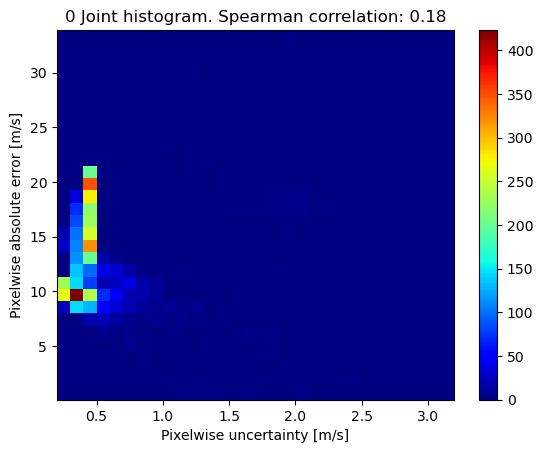

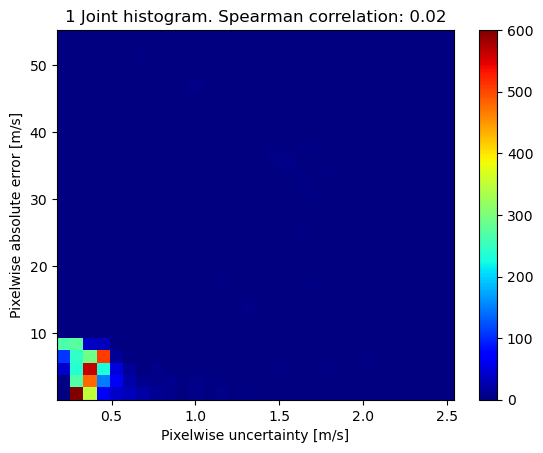

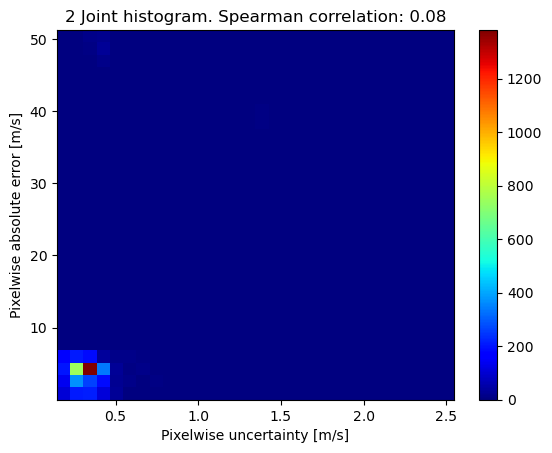

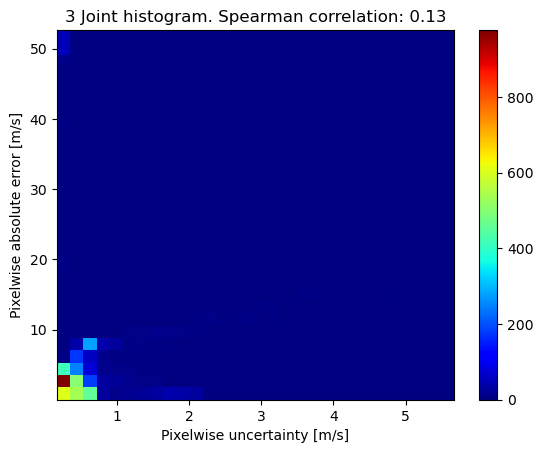

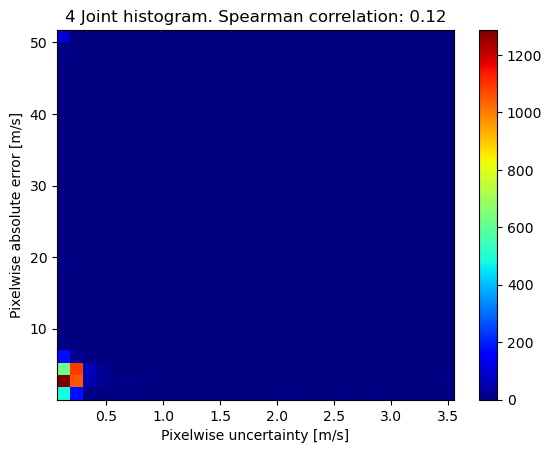

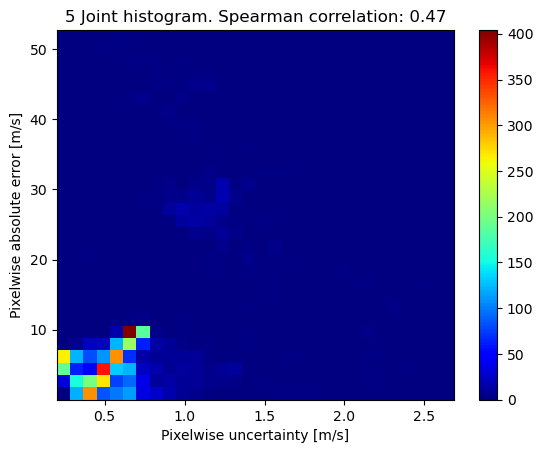

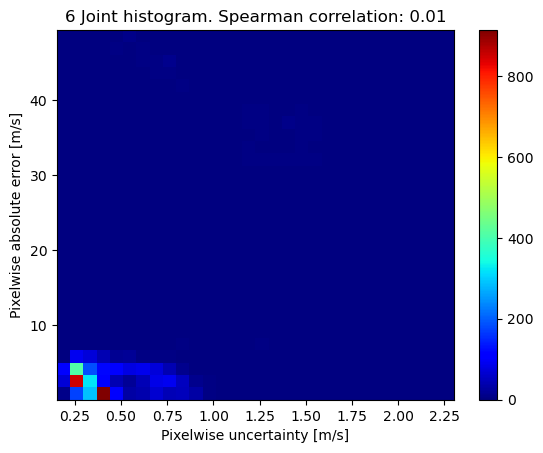

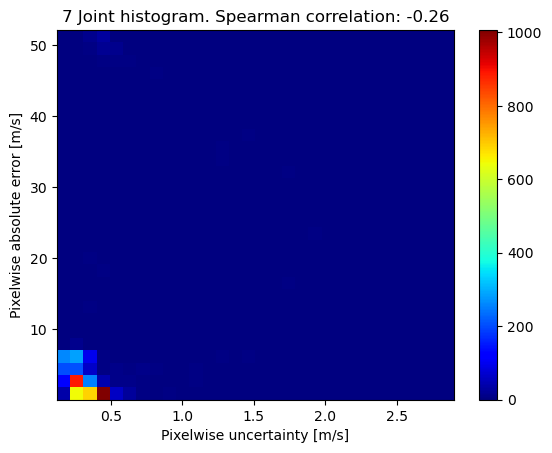

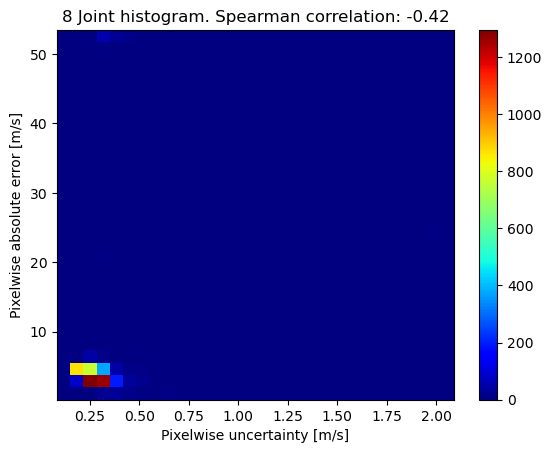

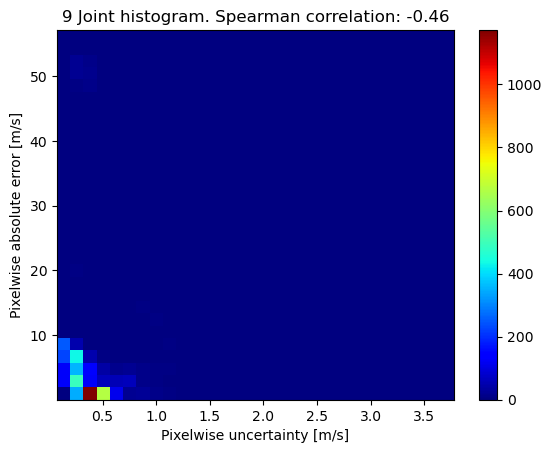

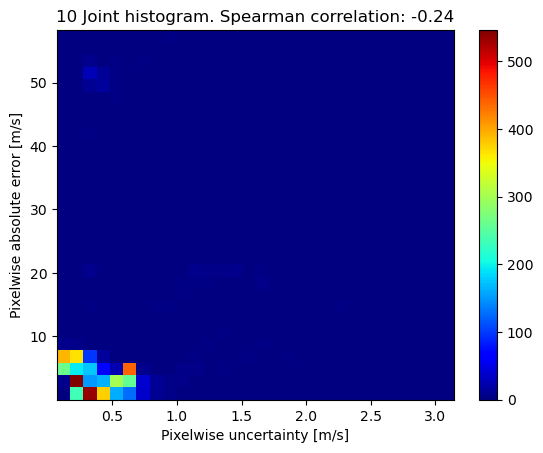

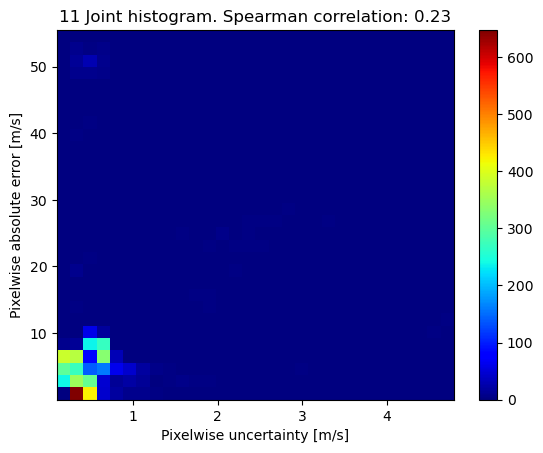

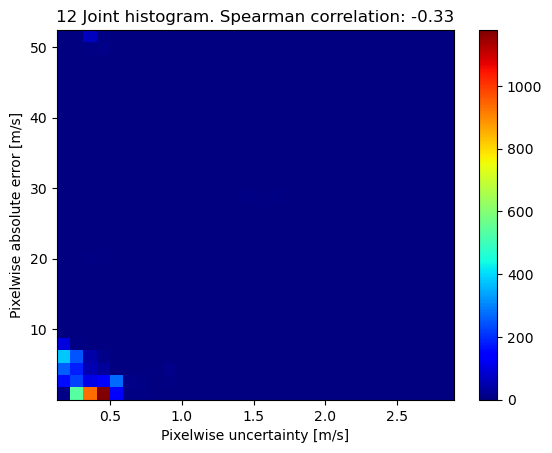

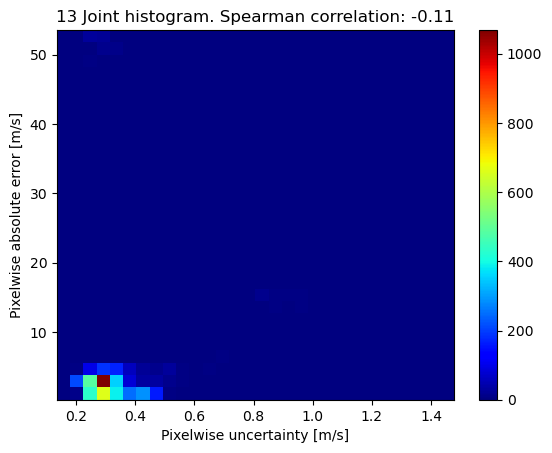

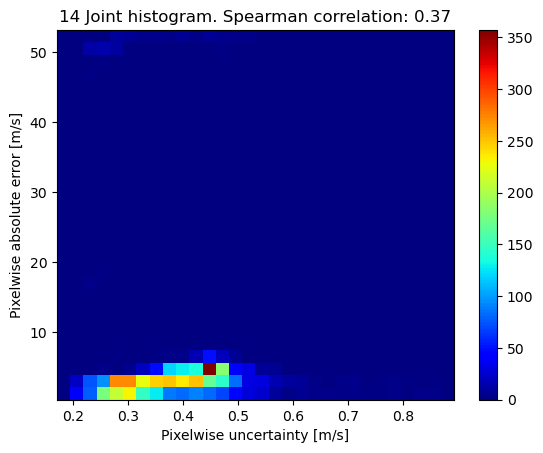

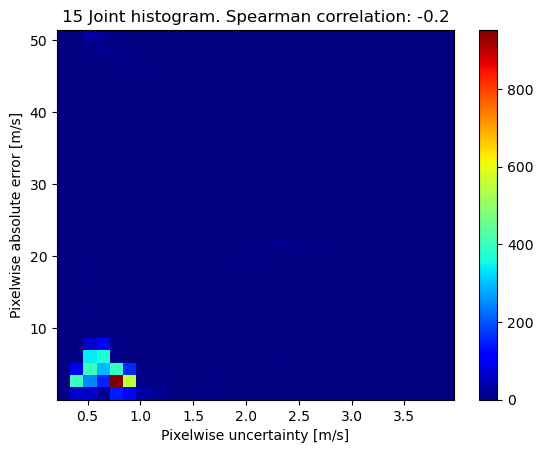

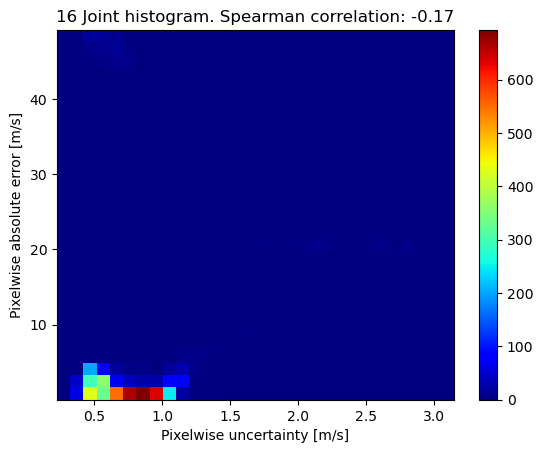

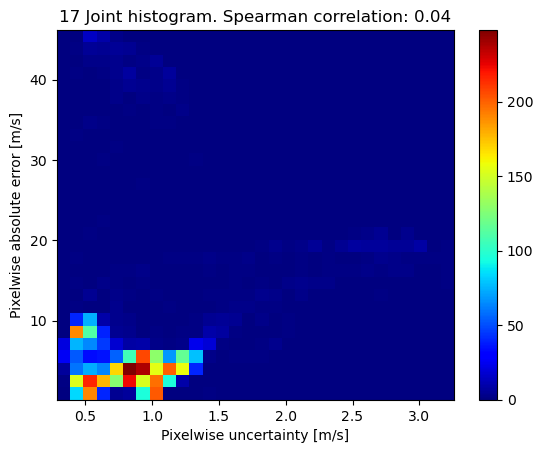

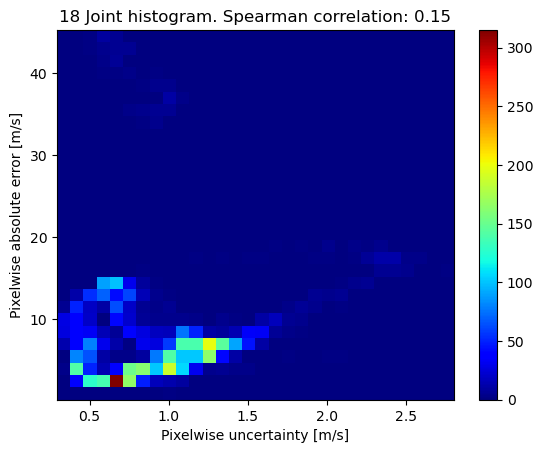

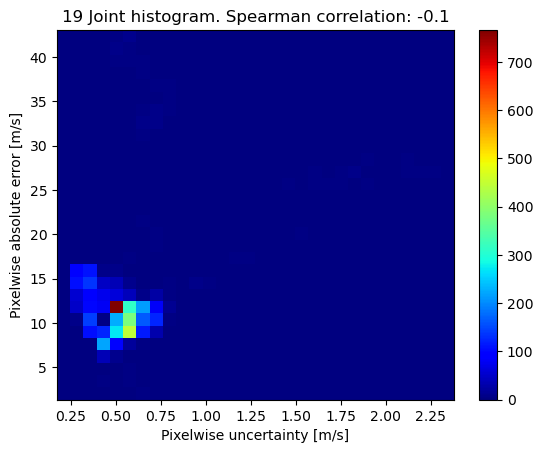

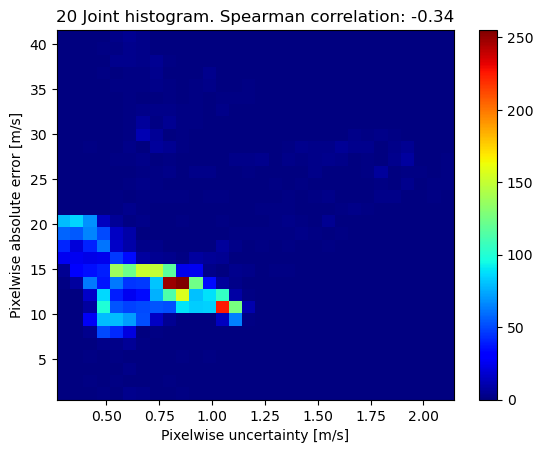

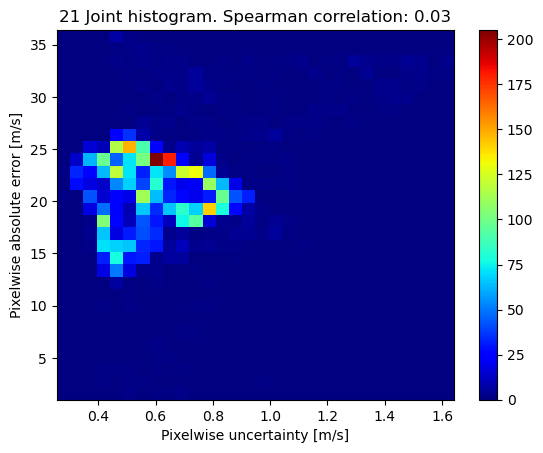

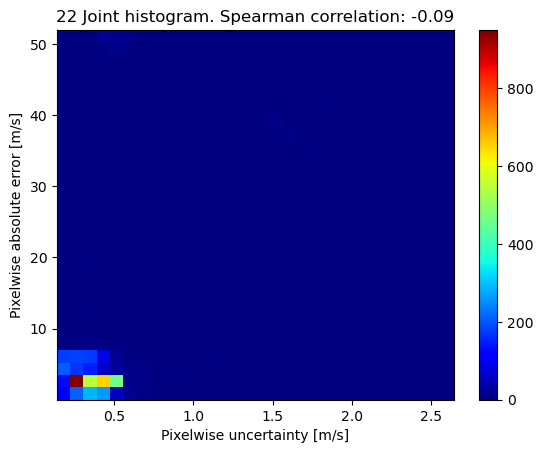

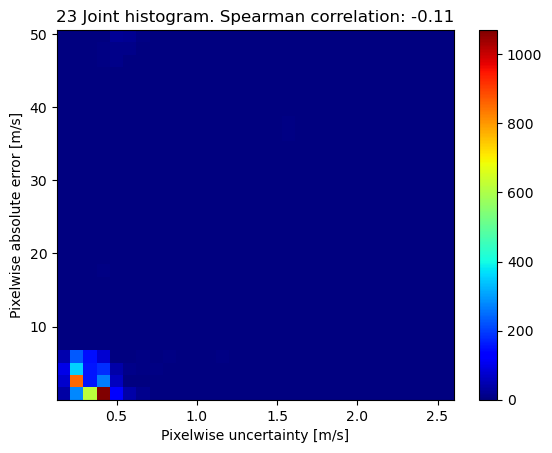

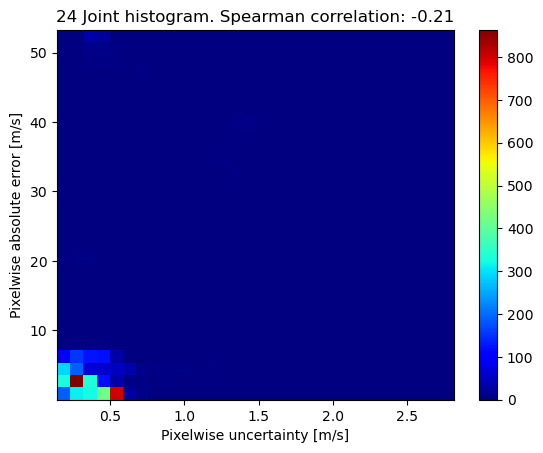

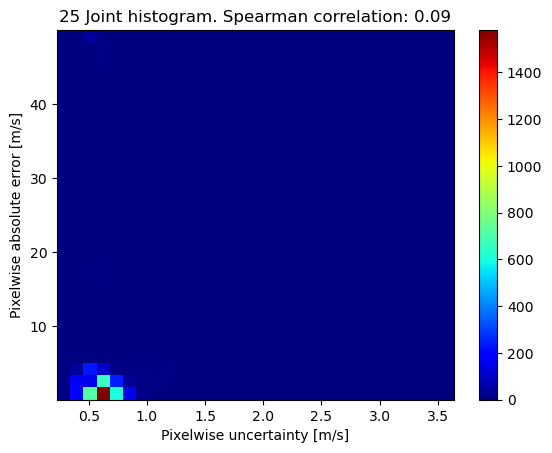

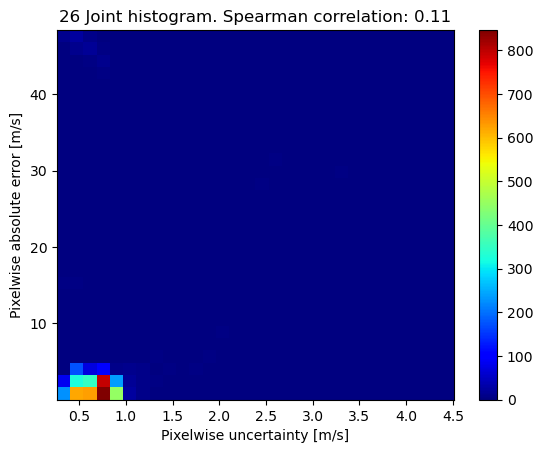

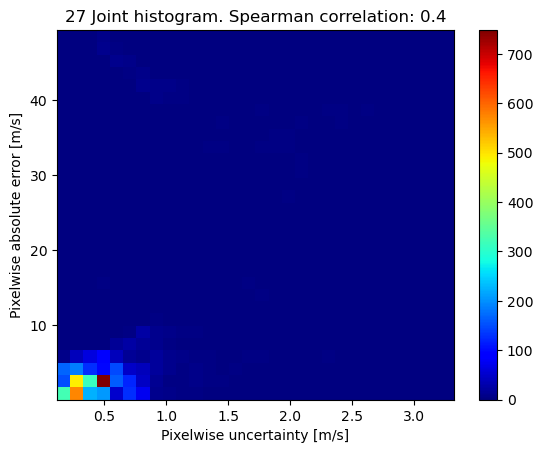

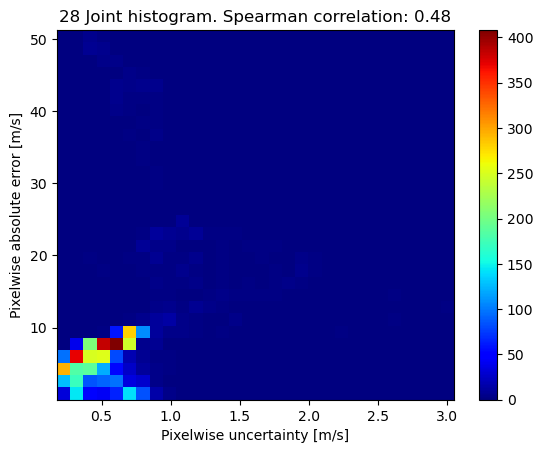

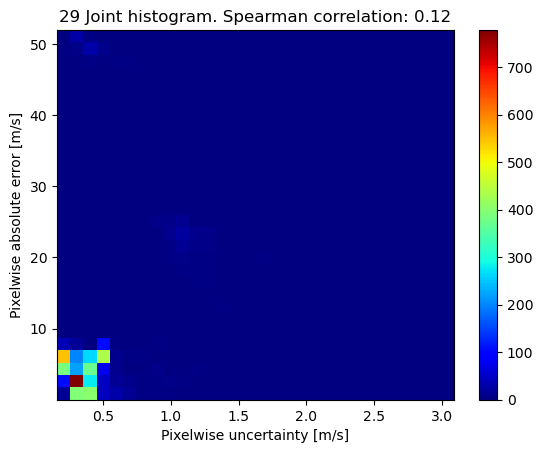

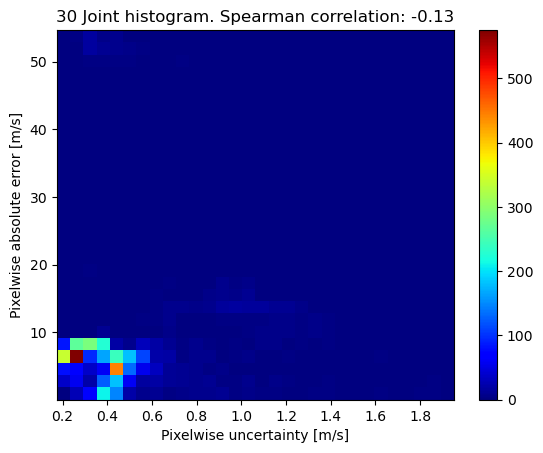

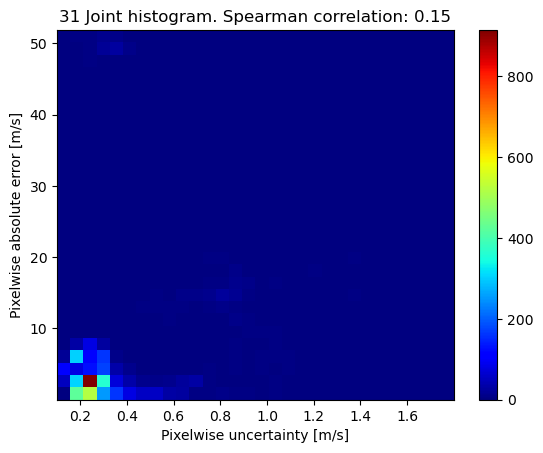

In [27]:
"""
Computing the pixelwise correlation as additional method for evaluation of relationship between uncertainty and error 
"""
for num in range(32):
    RMSE = np.abs(1/mat['gt_slowness'][num,...] - uncert['mean'][num,...])
    plt.hist2d(uncert['stdev'][num,...].ravel(),RMSE[0].ravel(),bins=(30, 30),
               cmap=plt.cm.jet)
    corr = spearmanr(uncert['stdev'][num,...].ravel(),RMSE[0].ravel()).correlation
    p1 = plt.colorbar()
    plt.title(str(num) + ' Joint histogram. Spearman correlation: ' + str(np.round(corr,decimals=2)))
    plt.xlabel('Pixelwise uncertainty [m/s]')
    plt.ylabel('Pixelwise absolute error [m/s]')
    plt.show()